In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install git+https://github.com/openai/CLIP.git
!pip install info-nce-pytorch

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-87d6bvdq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-87d6bvdq
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=3390b912dd87c96157787d86fa259908ee73cc6cc4173168f87d4acfbad07505
  Stored in directory: /tmp/pip-ephem-wheel-cache-jzlczbi7/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import clip
import os
import random
from torch.utils.data import Dataset, DataLoader, random_split
from info_nce import InfoNCE
import tqdm

In [4]:
# Load pre-trained CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Cast model parameters to FP32
for param in model.parameters():
    param.data = param.data.float()
    if param.grad is not None:
        param.grad.data = param.grad.data.float()


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 212MiB/s]


In [5]:
# Function to modify the CLIP model to accept 32x32 images
def modify_clip_model_for_32x32(model):
    # Modify the input projection layer
    #The conv1 layer's kernel size is reduced, and the stride is adjusted to account for the smaller input size.
    model.visual.conv1 = nn.Conv2d(in_channels=3, out_channels=model.visual.conv1.out_channels,
                                   kernel_size=3, stride=2, padding=1)
    # Update positional embeddings
    #The positional embeddings are updated to match the number of patches generated from 32x32 images.
    num_patches = (32 // model.visual.conv1.stride[0]) ** 2
    model.visual.positional_embedding = nn.Parameter(
        torch.randn(1, num_patches + 1, model.visual.positional_embedding.shape[-1])
    )
    return model

In [6]:
model = modify_clip_model_for_32x32(model).to(device)

In [7]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, text_file, transform=None, subset_fraction=1.0):
        self.image_dir = image_dir
        self.transform = transform
        self.image_caption_pairs = []
        with open(text_file, 'r') as f:
            lines = f.readlines()
            for line in lines[1:]:  # Skip the header line
                image_name, caption = line.strip().split(',', 1)
                self.image_caption_pairs.append((image_name, caption))

        # Randomly select subset of data
        if subset_fraction < 1.0:
            num_samples = int(len(self.image_caption_pairs) * subset_fraction)
            self.image_caption_pairs = random.sample(self.image_caption_pairs, num_samples)

    def __len__(self):
        return len(self.image_caption_pairs)

    def __getitem__(self, index):
        image_name, caption = self.image_caption_pairs[index]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, caption

In [8]:
# Function to get distorted images
def get_distorted_images(images, distortions):
    distorted_images = []
    for image in images:
        for distortion in distortions:
            if distortion == 'gaussian_blur':
                distorted_image = torchvision.transforms.functional.gaussian_blur(image, kernel_size=5)
            elif distortion == 'horizontal_flip':
                distorted_image = torchvision.transforms.functional.hflip(image)
            elif distortion == 'random_crop':
                random_crop = transforms.RandomCrop(size=(32, 32), padding=4)
                distorted_image = random_crop(image)
            distorted_images.append(distorted_image)
    return distorted_images

In [9]:
# Define the dataset
dataset = Flickr8kDataset(
    image_dir='/kaggle/input/flickr8k/Images',
    text_file= '/kaggle/input/flickr8k/captions.txt',
    transform=transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]), subset_fraction=0.1 
)
print(len(dataset))

4045


In [10]:
# Check a few samples from the dataset
for i in range(5):
    image, text = dataset[i]
    print("Caption:", text)
    # Convert tensor to PIL image and show
    pil_image = transforms.ToPILImage()(image)
    pil_image.show()
    break

Caption: A skateboarder in midair above an indoor ramp .


In [11]:
# Check the length of the dataset
dataset_length = len(dataset)
print("Dataset length:", dataset_length)

# Split the dataseta
train_size = int(0.6 * dataset_length)
val_size = int(0.1 * dataset_length)
test_size = dataset_length - train_size - val_size

print(train_size)
print(val_size)
print(test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Dataset length: 4045
2427
404
1214


In [12]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [13]:
# Create data loaders
batch_size = 16  # Reduced batch size
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmpqk0aqoko.PNG'


In [14]:
# Loss function and optimizer
loss_fn = InfoNCE(negative_mode='unpaired')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

In [15]:
# Training loop with validation
num_epochs = 5
best_val_loss = float('inf')
scaler = torch.cuda.amp.GradScaler()  # Mixed precision training

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    model.to(device)  # Ensure the model is on the correct device

    pbar = tqdm.tqdm(train_data_loader, total=len(train_data_loader))
    for batch in pbar:
        optimizer.zero_grad()
        images, texts = batch
        images = images.to(device)
        texts = clip.tokenize(texts).to(device)

        # Generate distorted images
        distorted_images = get_distorted_images(images, distortions=['gaussian_blur', 'horizontal_flip', 'random_crop'])
        distorted_images = torch.stack(distorted_images).to(device)

        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            original_image_embeddings = model.encode_image(images)
            distorted_image_embeddings = model.encode_image(distorted_images)
            text_embeddings = model.encode_text(texts)

            # Create positive pairs
            positive_pairs = list(zip(original_image_embeddings, text_embeddings)) + list(zip(distorted_image_embeddings, text_embeddings))

            # Create negative pairs
            negative_pairs = []
            for i in range(len(original_image_embeddings)):
                random_index = random.randint(0, len(original_image_embeddings) - 1)
                while random_index == i:
                    random_index = random.randint(0, len(original_image_embeddings) - 1)
                negative_pairs.append((original_image_embeddings[i], text_embeddings[random_index]))
                negative_pairs.append((distorted_image_embeddings[i], text_embeddings[random_index]))

            # Prepare embeddings for contrastive loss
            query_embeddings, positive_key_embeddings = zip(*positive_pairs)
            _, negative_key_embeddings = zip(*negative_pairs)

            query_embeddings = torch.stack(query_embeddings).to(device)
            positive_key_embeddings = torch.stack(positive_key_embeddings).to(device)
            negative_key_embeddings = torch.stack(negative_key_embeddings).to(device)

            # Calculate loss
            loss = loss_fn(query_embeddings, positive_key_embeddings, negative_key_embeddings)
            train_loss += loss.item()

        # Check for NaN loss
        if torch.isnan(loss):
            print("NaN loss detected. Skipping this batch.")
            continue

        # Mixed precision backward pass
        scaler.scale(loss).backward()
        # Cast gradients to FP32
        for param in model.parameters():
            if param.grad is not None:
                param.grad.data = param.grad.data.float()
        # Unscale gradients
        scaler.unscale_(optimizer)

        # Check for any inf/NaN values in the gradients
        for param in model.parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    print(f"Skipping update for a parameter due to NaN/Inf gradients in epoch {epoch+1}.")
                    continue

        # Perform the optimizer step
        scaler.step(optimizer)
        scaler.update()

        pbar.set_description(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_data_loader:
            images, texts = batch
            images = images.to(device)
            texts = clip.tokenize(texts).to(device)

            distorted_images = get_distorted_images(images, distortions=['gaussian_blur', 'horizontal_flip', 'random_crop'])
            distorted_images = torch.stack(distorted_images).to(device)

            with torch.cuda.amp.autocast():
                original_image_embeddings = model.encode_image(images)
                distorted_image_embeddings = model.encode_image(distorted_images)
                text_embeddings = model.encode_text(texts)

                positive_pairs = list(zip(original_image_embeddings, text_embeddings)) + list(zip(distorted_image_embeddings, text_embeddings))
                negative_pairs = []
                for i in range(len(original_image_embeddings)):
                    random_index = random.randint(0, len(original_image_embeddings) - 1)
                    while random_index == i:
                        random_index = random.randint(0, len(original_image_embeddings) - 1)
                    negative_pairs.append((original_image_embeddings[i], text_embeddings[random_index]))
                    negative_pairs.append((distorted_image_embeddings[i], text_embeddings[random_index]))

                query_embeddings, positive_key_embeddings = zip(*positive_pairs)
                _, negative_key_embeddings = zip(*negative_pairs)

                query_embeddings = torch.stack(query_embeddings).to(device)
                positive_key_embeddings = torch.stack(positive_key_embeddings).to(device)
                negative_key_embeddings = torch.stack(negative_key_embeddings).to(device)

                loss = loss_fn(query_embeddings, positive_key_embeddings, negative_key_embeddings)
                val_loss += loss.item()

    train_loss /= len(train_data_loader)
    val_loss /= len(val_data_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_clip_model.pt')


Epoch 1, Loss: 3.5807:   1%|▏         | 2/152 [00:04<05:35,  2.24s/it]

Skipping update for a parameter due to NaN/Inf gradients in epoch 1.
Skipping update for a parameter due to NaN/Inf gradients in epoch 1.


Epoch 1, Loss: 3.4650:   2%|▏         | 3/152 [00:06<05:01,  2.03s/it]

Skipping update for a parameter due to NaN/Inf gradients in epoch 1.


Epoch 1, Loss: 3.1337: 100%|██████████| 152/152 [04:32<00:00,  1.79s/it]


Epoch 1, Train Loss: 3.4958, Validation Loss: 3.4469


Epoch 2, Loss: 3.1337: 100%|██████████| 152/152 [04:22<00:00,  1.72s/it]


Epoch 2, Train Loss: 3.4948, Validation Loss: 3.4472


Epoch 3, Loss: 3.1356: 100%|██████████| 152/152 [04:21<00:00,  1.72s/it]


Epoch 3, Train Loss: 3.4951, Validation Loss: 3.4466


Epoch 4, Loss: 3.1344: 100%|██████████| 152/152 [04:22<00:00,  1.73s/it]


Epoch 4, Train Loss: 3.4960, Validation Loss: 3.4490


Epoch 5, Loss: 3.1310: 100%|██████████| 152/152 [04:22<00:00,  1.73s/it]


Epoch 5, Train Loss: 3.4946, Validation Loss: 3.4482


In [16]:
# Load the best model for testing
model.load_state_dict(torch.load('best_clip_model.pt'))
model.eval()

# Testing loop
test_loss = 0.0
with torch.no_grad():
    for batch in test_data_loader:
        images, texts = batch
        images = images.to(device)
        texts = clip.tokenize(texts).to(device)

        distorted_images = get_distorted_images(images, distortions=['gaussian_blur', 'horizontal_flip', 'random_crop'])
        distorted_images = torch.stack(distorted_images).to(device)

        with torch.cuda.amp.autocast():
            original_image_embeddings = model.encode_image(images)
            distorted_image_embeddings = model.encode_image(distorted_images)
            text_embeddings = model.encode_text(texts)

            positive_pairs = list(zip(original_image_embeddings, text_embeddings)) + list(zip(distorted_image_embeddings, text_embeddings))
            negative_pairs = []
            for i in range(len(original_image_embeddings)):
                random_index = random.randint(0, len(original_image_embeddings) - 1)
                while random_index == i:
                    random_index = random.randint(0, len(original_image_embeddings) - 1)
                negative_pairs.append((original_image_embeddings[i], text_embeddings[random_index]))
                negative_pairs.append((distorted_image_embeddings[i], text_embeddings[random_index]))

            query_embeddings, positive_key_embeddings = zip(*positive_pairs)
            _, negative_key_embeddings = zip(*negative_pairs)

            query_embeddings = torch.stack(query_embeddings).to(device)
            positive_key_embeddings = torch.stack(positive_key_embeddings).to(device)
            negative_key_embeddings = torch.stack(negative_key_embeddings).to(device)

            loss = loss_fn(query_embeddings, positive_key_embeddings, negative_key_embeddings)
            test_loss += loss.item()

test_loss /= len(test_data_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 3.4947


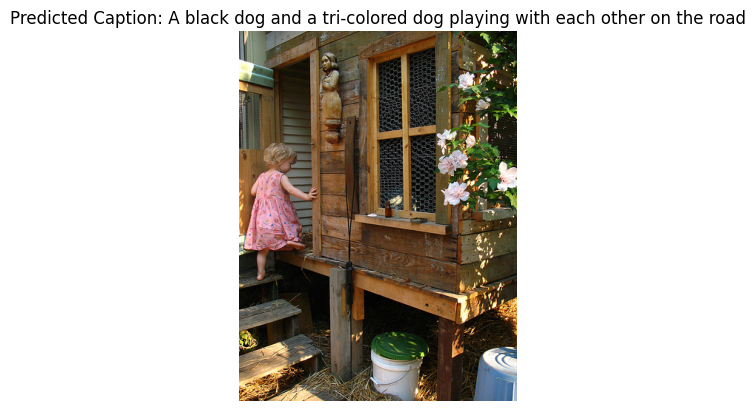

Caption: A child in a pink dress is climbing up a set of stairs in an entry way. | Similarity: 0.9353
Caption: A girl going into a wooden buildingA little girl climbing into a wooden playhouse | Similarity: 0.9352
Caption: A black dog and a tri-colored dog playing with each other on the road | Similarity: 0.9354


In [17]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Load the best model checkpoint
model.load_state_dict(torch.load('best_clip_model.pt'))
model.eval()

# Ensure the image is resized to 32x32 for the modified CLIP model
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0).to(device)

# Function to visualize results
def visualize_prediction(image_path, captions):
    # Load and preprocess the image
    image = preprocess_image(image_path)
    
    # Generate image embedding
    with torch.no_grad():
        image_embedding = model.encode_image(image)

    # Tokenize and generate text embeddings for all candidate captions
    text_tokens = clip.tokenize(captions).to(device)
    with torch.no_grad():
        text_embeddings = model.encode_text(text_tokens)

    # Calculate cosine similarity between image and text embeddings
    similarities = torch.nn.functional.cosine_similarity(image_embedding, text_embeddings)

    # Find the caption with the highest similarity score
    best_idx = torch.argmax(similarities).item()
    predicted_caption = captions[best_idx]

    # Visualize the image and the predicted caption
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted Caption: {predicted_caption}")
    plt.axis('off')
    plt.show()

    # Print all captions with their similarity scores
    for i, caption in enumerate(captions):
        print(f"Caption: {caption} | Similarity: {similarities[i].item():.4f}")

# Example usage
image_path = "/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg"
candidate_captions = [
    "A child in a pink dress is climbing up a set of stairs in an entry way.",
    "A girl going into a wooden building"
    "A little girl climbing into a wooden playhouse",
    "A black dog and a tri-colored dog playing with each other on the road",
    
    
]

visualize_prediction(image_path, candidate_captions)

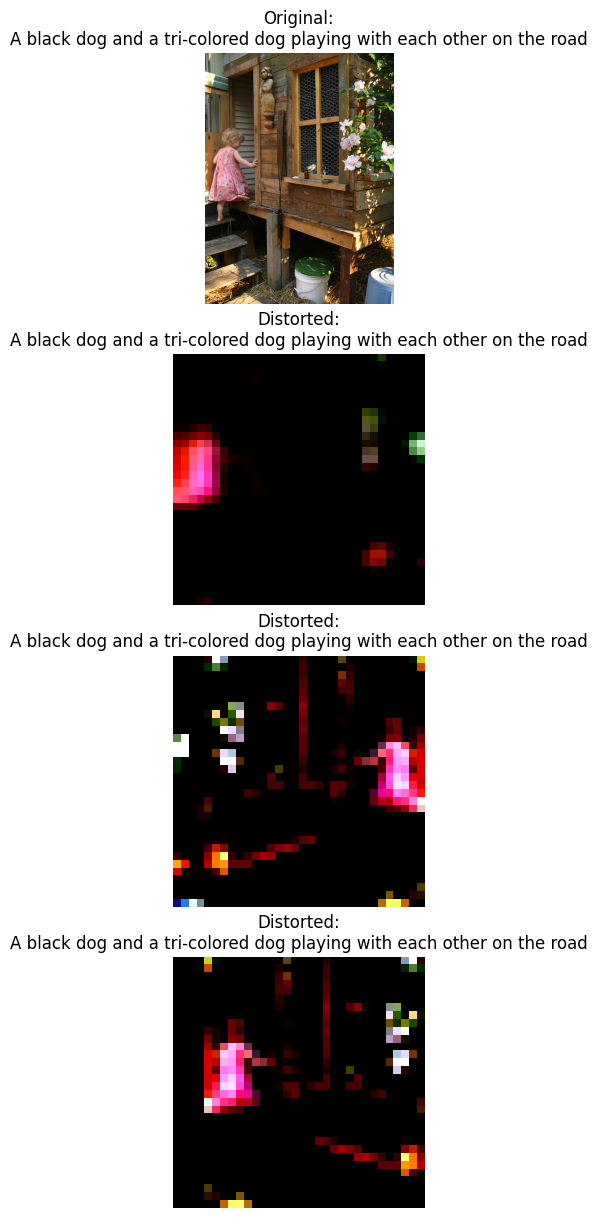

Original Image Similarities:
Caption: A child in a pink dress is climbing up a set of stairs in an entry way. | Similarity: 0.9353
Caption: A girl going into a wooden buildingA little girl climbing into a wooden playhouse | Similarity: 0.9352
Caption: A black dog and a tri-colored dog playing with each other on the road | Similarity: 0.9354
Distorted Image 1 Predicted Caption: A black dog and a tri-colored dog playing with each other on the road
Distorted Image 2 Predicted Caption: A black dog and a tri-colored dog playing with each other on the road
Distorted Image 3 Predicted Caption: A black dog and a tri-colored dog playing with each other on the road


In [18]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Load the best model checkpoint
model.load_state_dict(torch.load('best_clip_model.pt'))
model.eval()

# Ensure the image is resized to 32x32 for the modified CLIP model
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0).to(device)

# Function to apply distortions
def apply_distortions(image, distortions):
    distorted_images = get_distorted_images(image, distortions)
    return torch.stack(distorted_images)

# Function to visualize predictions with and without distortions
def visualize_prediction_with_distortions(image_path, captions, distortions):
    # Load and preprocess the image
    image = preprocess_image(image_path)
    
    # Generate image embedding for the original image
    with torch.no_grad():
        original_embedding = model.encode_image(image)

    # Tokenize and generate text embeddings for all candidate captions
    text_tokens = clip.tokenize(captions).to(device)
    with torch.no_grad():
        text_embeddings = model.encode_text(text_tokens)

    # Calculate cosine similarity for the original image
    original_similarities = torch.nn.functional.cosine_similarity(original_embedding, text_embeddings)
    best_original_idx = torch.argmax(original_similarities).item()
    original_caption = captions[best_original_idx]

    # Apply distortions and generate embeddings
    distorted_images = apply_distortions(image, distortions)
    distorted_captions = []
    for distorted_image in distorted_images:
        with torch.no_grad():
            distorted_embedding = model.encode_image(distorted_image.unsqueeze(0))
        distorted_similarities = torch.nn.functional.cosine_similarity(distorted_embedding, text_embeddings)
        best_distorted_idx = torch.argmax(distorted_similarities).item()
        distorted_captions.append(captions[best_distorted_idx])

    # Visualize the original and distorted images with predictions
    fig, axs = plt.subplots(len(distorted_images) + 1, 1, figsize=(5, 15))
    
    # Display original image and prediction
    axs[0].imshow(Image.open(image_path))
    axs[0].set_title(f"Original:\n{original_caption}")
    axs[0].axis('off')

    # Display distorted images and predictions
    for i, distorted_image in enumerate(distorted_images):
        distorted_image_np = distorted_image.permute(1, 2, 0).cpu().numpy()
        axs[i + 1].imshow(distorted_image_np)
        axs[i + 1].set_title(f"Distorted:\n{distorted_captions[i]}")
        axs[i + 1].axis('off')

    plt.show()

    # Print all captions with their similarity scores for the original image
    print("Original Image Similarities:")
    for i, caption in enumerate(captions):
        print(f"Caption: {caption} | Similarity: {original_similarities[i].item():.4f}")

    # Print all captions with their similarity scores for the distorted images
    for i, distorted_caption in enumerate(distorted_captions):
        print(f"Distorted Image {i + 1} Predicted Caption: {distorted_caption}")

# Example usage
image_path = "/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg"
candidate_captions = [
    "A child in a pink dress is climbing up a set of stairs in an entry way.",
    "A girl going into a wooden building"
    "A little girl climbing into a wooden playhouse",
    "A black dog and a tri-colored dog playing with each other on the road",
]

distortions = ['gaussian_blur', 'horizontal_flip', 'random_crop']
visualize_prediction_with_distortions(image_path, candidate_captions, distortions)


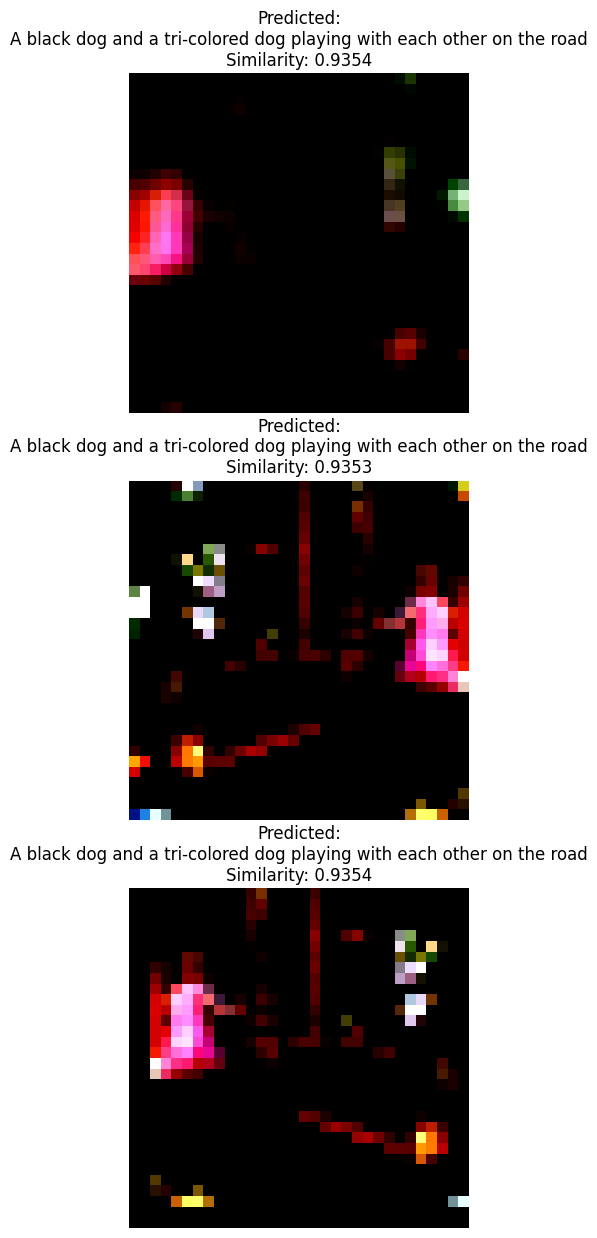

Distorted Image 1 Predicted Caption: A black dog and a tri-colored dog playing with each other on the road | Similarity: 0.9354
Distorted Image 2 Predicted Caption: A black dog and a tri-colored dog playing with each other on the road | Similarity: 0.9353
Distorted Image 3 Predicted Caption: A black dog and a tri-colored dog playing with each other on the road | Similarity: 0.9354


In [19]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Load the best model checkpoint
model.load_state_dict(torch.load('best_clip_model.pt'))
model.eval()

# Ensure the image is resized to 32x32 for the modified CLIP model
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0).to(device)

# Function to apply distortions
def apply_distortions(image, distortions):
    distorted_images = get_distorted_images([image.squeeze(0)], distortions)
    return torch.stack(distorted_images).to(device)

# Function to visualize predictions for distorted images only
def visualize_distorted_predictions(image_path, captions, distortions):
    # Load and preprocess the image
    image = preprocess_image(image_path)
    
    # Tokenize and generate text embeddings for all candidate captions
    text_tokens = clip.tokenize(captions).to(device)
    with torch.no_grad():
        text_embeddings = model.encode_text(text_tokens)

    # Apply distortions and generate embeddings
    distorted_images = apply_distortions(image, distortions)
    distorted_captions = []
    distorted_similarities = []
    for distorted_image in distorted_images:
        with torch.no_grad():
            distorted_embedding = model.encode_image(distorted_image.unsqueeze(0))
        similarities = torch.nn.functional.cosine_similarity(distorted_embedding, text_embeddings)
        best_idx = torch.argmax(similarities).item()
        distorted_captions.append(captions[best_idx])
        distorted_similarities.append(similarities[best_idx].item())

    # Visualize distorted images with predictions
    
    fig, axs = plt.subplots(len(distorted_images), 1, figsize=(5, 15))
    
    # Display distorted images and predictions
    for i, distorted_image in enumerate(distorted_images):
        distorted_image_np = distorted_image.permute(1, 2, 0).cpu().numpy()
        axs[i].imshow(distorted_image_np)
        axs[i].set_title(f"Predicted:\n{distorted_captions[i]}\nSimilarity: {distorted_similarities[i]:.4f}")
        axs[i].axis('off')

    plt.show()

    # Print all captions with their similarity scores for the distorted images
    for i, caption in enumerate(distorted_captions):
        print(f"Distorted Image {i + 1} Predicted Caption: {caption} | Similarity: {distorted_similarities[i]:.4f}")

# Example usage
image_path = "/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg"
candidate_captions = [
    "A child in a pink dress is climbing up a set of stairs in an entry way.",
    "A girl going into a wooden building"
    "A little girl climbing into a wooden playhouse",
    "A black dog and a tri-colored dog playing with each other on the road",
]

distortions = ['gaussian_blur', 'horizontal_flip', 'random_crop']
visualize_distorted_predictions(image_path, candidate_captions, distortions)